In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
from dataclasses import dataclass
from enum import StrEnum

from lib import *
from patientInfo import PatientInfo, Scan
import patientInfo

import seaborn as sns

In [2]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [3]:
train_df = pd.read_csv("./data/train.csv")
train_label_coordinates_df = pd.read_csv("./data/train_label_coordinates.csv")
train_series_descriptions_df = pd.read_csv("./data/train_series_descriptions.csv")

In [4]:
train_label_coordinates_df.columns

Index(['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x',
       'y'],
      dtype='object')

In [5]:
train_label_coordinates_df.head()

study_id  series_id  instance_number              condition  level  \
0   4003253  702807833                8  Spinal Canal Stenosis  L1/L2   
1   4003253  702807833                8  Spinal Canal Stenosis  L2/L3   
2   4003253  702807833                8  Spinal Canal Stenosis  L3/L4   
3   4003253  702807833                8  Spinal Canal Stenosis  L4/L5   
4   4003253  702807833                8  Spinal Canal Stenosis  L5/S1   

            x           y  
0  322.831858  227.964602  
1  320.571429  295.714286  
2  323.030303  371.818182  
3  335.292035  427.327434  
4  353.415929  483.964602

In [6]:
label_series_ids = train_label_coordinates_df["series_id"].unique()

train_label_coordinates_df["series_description"] = train_label_coordinates_df["series_id"]
condition_df = train_series_descriptions_df[train_series_descriptions_df["series_id"].isin(label_series_ids)].drop(columns=["study_id"])
train_label_coordinates_df["series_description"] = train_label_coordinates_df["series_description"].map(pd.Series(condition_df["series_description"].values,index=condition_df["series_id"]).to_dict())


In [7]:
train_label_coordinates_df[["series_description", "condition"]].value_counts()

series_description  condition                       
Sagittal T1         Left Neural Foraminal Narrowing     9860
                    Right Neural Foraminal Narrowing    9859
Sagittal T2/STIR    Spinal Canal Stenosis               9748
Axial T2            Right Subarticular Stenosis         9612
                    Left Subarticular Stenosis          9608
Sagittal T1         Spinal Canal Stenosis                  5
Name: count, dtype: int64

In [8]:
patient_ids = train_df["study_id"].unique()
train_img_dir = "./data/train_images/"


In [9]:
def display_images(patient_info: PatientInfo, scan, idxs=[], only_show_labelled_images=True, show_labels=True, radius = 10, color=(255,0,0), thickness=2):


    for img in patient_info.get_scans(scan):

        pixels = img.dicom.pixel_array
        pixels = cv2.normalize(img.dicom.pixel_array, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        labels = []

        if img.has_label():
            for label in img.labels:
                labels.append(label)
                center_coordinates = (int(label.x), int(label.y))
                pixels = cv2.circle(pixels.copy(), center_coordinates, radius, color, thickness)
            
            
        if img.has_label() or ((not only_show_labelled_images) or img.SOPInstanceUID in idxs):
            print(f"{scan=} | {img.SOPInstanceUID=} | {img.dicom.PixelSpacing=} | {img.dicom.ImagePositionPatient=}")

            for label in labels:
                print(f"(x={label.x},y={label.y}), {label.location.to_str()}, {patient_info.conditions[label.location.to_str()]}")
            plt.imshow(pixels, cmap="gray")
            plt.axis("off")
            plt.show()

In [10]:
patient_info = PatientInfo.from_df(patient_ids[5], train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")

print(f"patient_id: {patient_info.patient_id}")

count_labels = 0

for scan in Scan.all_scans():
    
    unique_shape = []
    # print(patient_info.get_scans(scan))
    # print(scan)
    count_labels += sum([len(img.labels) for img in patient_info.get_scans(scan)])
    
print(f"Total img label: {count_labels}")

patient_id: 11340341
Total img label: 25


In [11]:
# patient_info.get_scans(Scan.AxialT2)

In [12]:

# display_images(patient_info, Scan.AxialT2)

In [13]:
# display_images(patient_info, Scan.SagittalT1)

In [14]:
# display_images(patient_info, Scan.SagittalT2_STIR)

In [ ]:
train_label_coordinates_df.head()

In [28]:
dist = []

for patient_id in tqdm(patient_ids):
    patient_info = PatientInfo.from_df(patient_id, train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")

    for img in patient_info.get_scans(Scan.AxialT2):
        if len(img.labels) == 2:
            img, labels = img.resize(512,512)
            c1 = (labels[0].x, labels[0].y)
            c2 = (labels[1].x, labels[1].y)
            dist.append(np.linalg.norm([c1[0] - c2[0], c1[1] - c2[1] ]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1975/1975 [01:15<00:00, 26.27it/s]


In [ ]:
type(patient_info.get_scans(Scan.AxialT2))

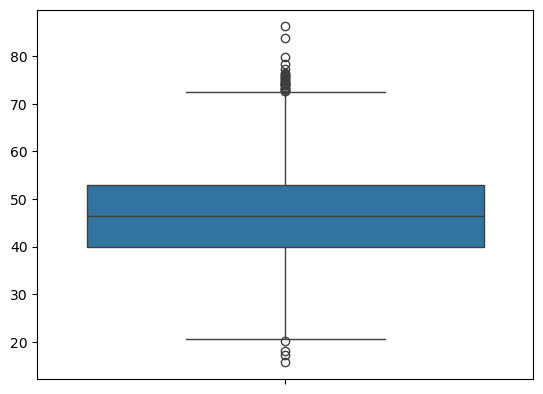

In [29]:
sns.boxplot(dist)
plt.show()

In [30]:
np.median(dist), np.std(dist)

(46.34512296804934, 9.552575711630347)

In [15]:
small_dists = {}
large_dists = {}

for patient_id in tqdm(patient_ids):
    patient_info = PatientInfo.from_df(patient_id, train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")

    for img in patient_info.get_scans(Scan.AxialT2):
        if len(img.labels) == 2:
            c1 = (img.labels[0].x, img.labels[0].y)
            c2 = (img.labels[1].x, img.labels[1].y)

            if (38.35 + 15) < (d := np.linalg.norm([c1[0] - c2[0], c1[1] - c2[1] ])):

                if patient_id in large_dists:
                    large_dists[patient_id].append((img.SOPInstanceUID, d))
                else:
                    large_dists[patient_id] = [(img.SOPInstanceUID, d)]
            elif (38.35 - 15) > (d := np.linalg.norm([c1[0] - c2[0], c1[1] - c2[1] ])):

                if patient_id in small_dists:
                    small_dists[patient_id].append((img.SOPInstanceUID, d))
                else:
                    small_dists[patient_id] = [(img.SOPInstanceUID, d)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1975/1975 [00:55<00:00, 35.41it/s]


In [16]:
len(large_dists), len(small_dists)

(523, 287)

In [17]:
small_dists[413910863]

[(8, 16.166641702404124),
 (18, 16.296381039663295),
 (23, 12.841832844316261),
 (29, 14.824282107495849)]

In [18]:
large_patient_info = PatientInfo.from_df(4183027129, train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=5 | img.dicom.PixelSpacing=[0.25, 0.25] | img.dicom.ImagePositionPatient=[-77.768521838276, -6.97388162657, -420.9950985487]
(x=381.7345132743363,y=356.53097345132744), left_subarticular_stenosis_l1_l2, Normal/Mild
(x=305.97713097713097,y=346.6112266112266), right_subarticular_stenosis_l1_l2, Normal/Mild


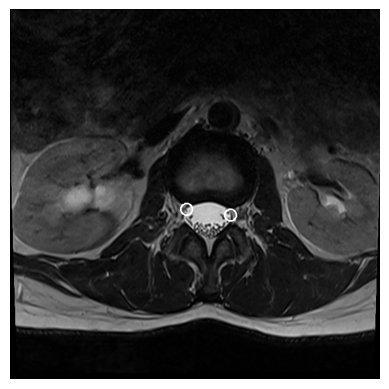

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=14 | img.dicom.PixelSpacing=[0.25, 0.25] | img.dicom.ImagePositionPatient=[-78.20396641039, -11.62743002532, -457.61288927585]
(x=385.13274336283183,y=347.46902654867256), left_subarticular_stenosis_l2_l3, Normal/Mild
(x=305.97713097713097,y=335.96673596673594), right_subarticular_stenosis_l2_l3, Normal/Mild


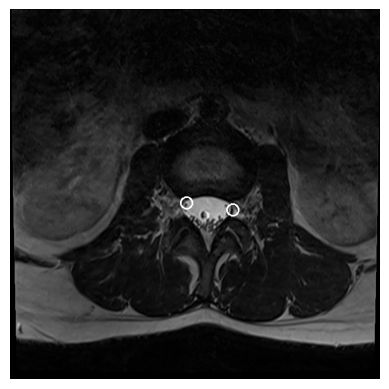

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=23 | img.dicom.PixelSpacing=[0.25, 0.25] | img.dicom.ImagePositionPatient=[-78.659485957307, -12.632237240909, -504.10756913542]
(x=376.070796460177,y=335.0088495575221), left_subarticular_stenosis_l3_l4, Normal/Mild
(x=299.3243243243243,y=327.983367983368), right_subarticular_stenosis_l3_l4, Normal/Mild


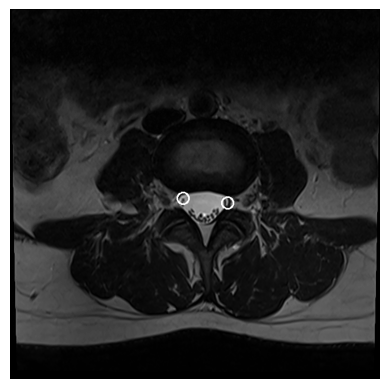

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=31 | img.dicom.PixelSpacing=[0.25, 0.25] | img.dicom.ImagePositionPatient=[-79.05966007856, -6.7328405695867, -547.34310181931]
(x=374.9380530973451,y=327.07964601769913), left_subarticular_stenosis_l4_l5, Normal/Mild
(x=294.002079002079,y=323.991683991684), right_subarticular_stenosis_l4_l5, Normal/Mild


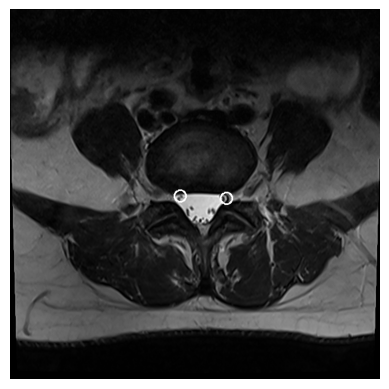

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=41 | img.dicom.PixelSpacing=[0.25, 0.25] | img.dicom.ImagePositionPatient=[-78.527395792231, 7.7707773873278, -587.71571340252]
(x=365.87610619469024,y=325.94690265486724), left_subarticular_stenosis_l5_s1, Moderate
(x=294.002079002079,y=334.63617463617464), right_subarticular_stenosis_l5_s1, Moderate


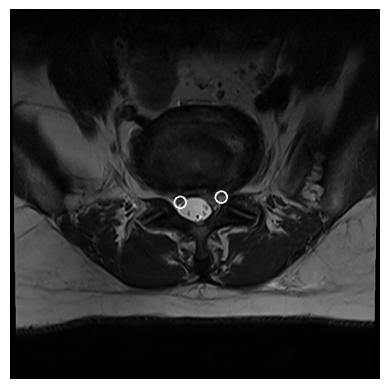

In [19]:
display_images(large_patient_info, Scan.AxialT2)

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=3 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-99.523517069089, 13.577492132085, 73.292783251676]
(x=141.7814910025707,y=103.23907455012854), left_subarticular_stenosis_l1_l2, Normal/Mild


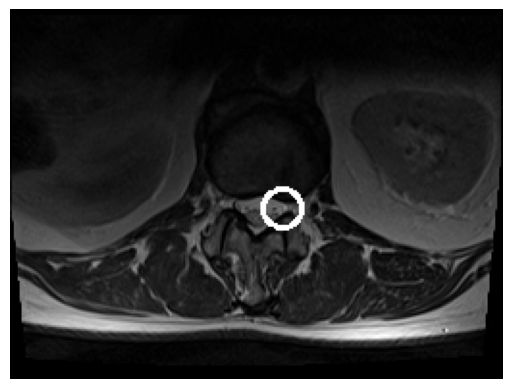

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=8 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-96.846656418256, 7.4782516267186, 38.132010248062]
(x=131.58097686375322,y=98.63239074550128), left_subarticular_stenosis_l2_l3, Severe
(x=115.45098039215686,y=97.5444947209653), right_subarticular_stenosis_l1_l2, Moderate


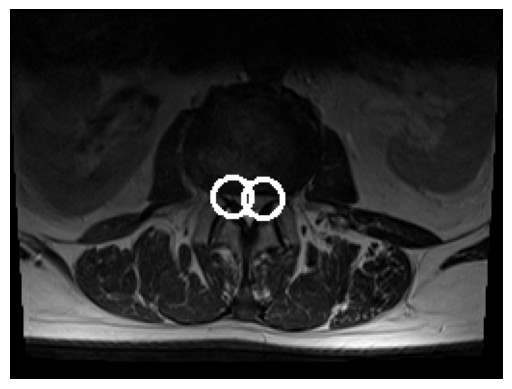

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=13 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-99.777390210135, 4.8537215963122, 9.8223057470655]
(x=115.8371040723982,y=93.2971342383107), right_subarticular_stenosis_l2_l3, Moderate


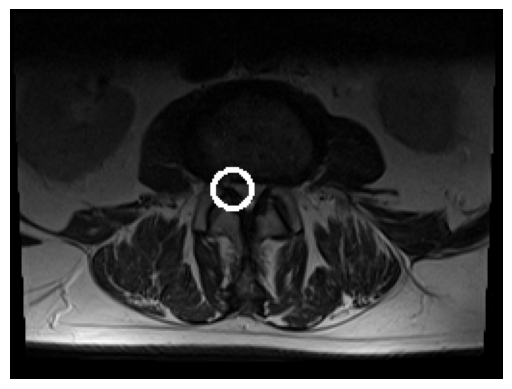

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=18 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-100.07342491309, 0.38161295602791, -39.400679010582]
(x=131.91002570694087,y=93.69665809768638), left_subarticular_stenosis_l3_l4, Moderate
(x=115.8371040723982,y=96.38612368024133), right_subarticular_stenosis_l3_l4, Moderate


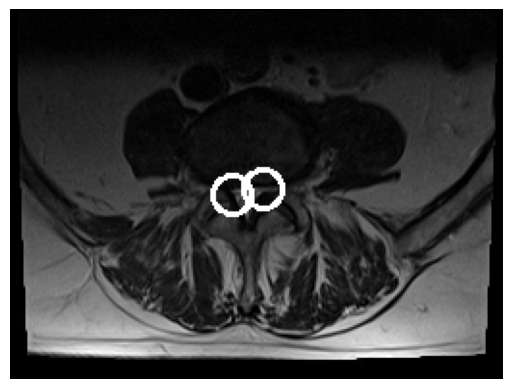

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=23 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-100.23241601558, 8.824496972106, -78.646159727653]
(x=135.20051413881748,y=95.34190231362469), left_subarticular_stenosis_l4_l5, Severe
(x=122.40120663650076,y=96.38612368024133), right_subarticular_stenosis_l4_l5, Moderate


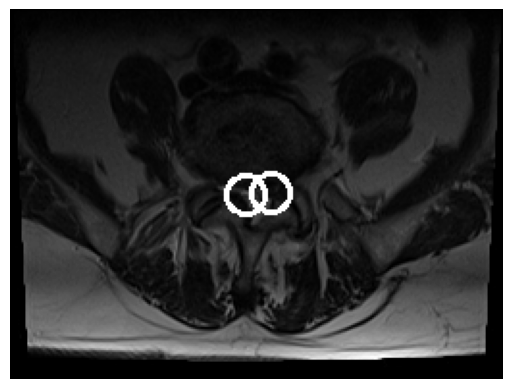

scan=<Scan.AxialT2: 'Axial T2'> | img.SOPInstanceUID=29 | img.dicom.PixelSpacing=[0.859375, 0.859375] | img.dicom.ImagePositionPatient=[-100.38896987233, 34.578649672348, -128.28272233618]
(x=130.26478149100257,y=96.98714652956298), left_subarticular_stenosis_l5_s1, Moderate
(x=115.45098039215686,y=97.5444947209653), right_subarticular_stenosis_l5_s1, Severe


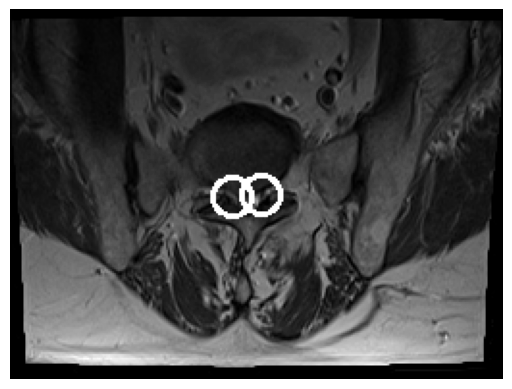

In [20]:
small_patient_info = PatientInfo.from_df(413910863, train_df, train_series_descriptions_df, train_label_coordinates_df, "./data/train_images")
display_images(small_patient_info, Scan.AxialT2)

In [21]:
small_img, small_labels = small_patient_info.get_scans(Scan.AxialT2)[7].resize(512,512)
large_img, large_labels = large_patient_info.get_scans(Scan.AxialT2)[30].resize(512,512)

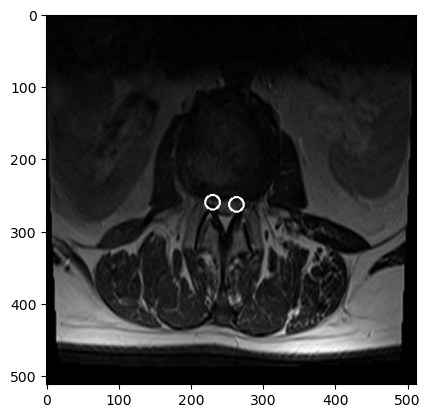

In [22]:

small_img = cv2.normalize(small_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
for label in small_labels:

    c = (int(label.x), int(label.y))
    small_img = cv2.circle(small_img.copy(), c, 10, (255,0,0), 2)

plt.imshow(small_img, cmap="gray")
plt.show()


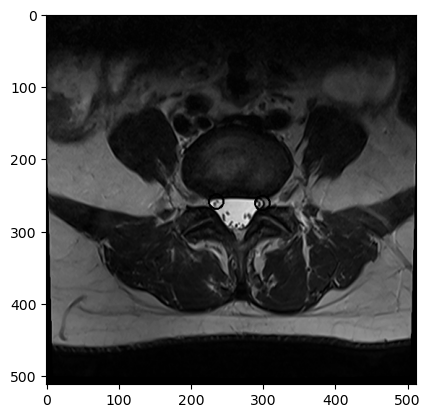

In [23]:

large_img = cv2.normalize(large_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
for label in large_labels:

    c = (int(label.x), int(label.y))
    large_img = cv2.circle(large_img.copy(), c, 10, (0,255,0), 2)

plt.imshow(large_img, cmap="gray")
plt.show()

In [24]:
np.linalg.norm([small_labels[0].x - small_labels[1].x, small_labels[0].y - small_labels[1].y])

32.39017244457966

In [25]:

np.linalg.norm([large_labels[0].x - large_labels[1].x, large_labels[0].y - large_labels[1].y])

64.79588832497915

In [26]:
large_labels

[ImgLabel(x=299.9504424778761, y=261.66371681415933, location=Location(disc_level=<DiscLevel.l4_l5: 'l4_l5'>, condition=<Condition.LSS: 'left_subarticular_stenosis'>)),
 ImgLabel(x=235.2016632016632, y=259.1933471933472, location=Location(disc_level=<DiscLevel.l4_l5: 'l4_l5'>, condition=<Condition.RSS: 'right_subarticular_stenosis'>))]

In [27]:
large_patient_info.get_scans(Scan.AxialT2)[30].labels

[ImgLabel(x=374.9380530973451, y=327.07964601769913, location=Location(disc_level=<DiscLevel.l4_l5: 'l4_l5'>, condition=<Condition.LSS: 'left_subarticular_stenosis'>)),
 ImgLabel(x=294.002079002079, y=323.991683991684, location=Location(disc_level=<DiscLevel.l4_l5: 'l4_l5'>, condition=<Condition.RSS: 'right_subarticular_stenosis'>))]